# Обучение U-net

 U-net для сегментации автомобилей. Подобная задача может быть актуальной для маркетплейсов, когда требуется отделить товар от фона, на котором он сфотографирован. Задание включает в себя:



1.   Загрузку и предобработку датасета из kaggle;
2.   Определение архитектуры U-net;
3.   Настройку пайплайна обучения.





## 1. Датасет

Мы воспользуеся датасетом [Carvana](https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview), который уже содержит необходимые изображения и маски. Чтобы получить доступ к датасету, необходимо 1) зарегистрироваться на kaggle, 2) сгенерировать ключ, 3) вступить в соревнование, 4) загрузить датасет через kaggle API

In [1]:
#!pip install kagglehub

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
# import albumentations as A
import json
import zipfile

In [3]:
# !export KAGGLE_USERNAME=leimangmailcom
# !export KAGGLE_KEY=fbf855cd83c345g12a2a72f39f6d72e0


In [4]:
# !mkdir -p ~/.kaggle
# !cp /home/maksim/Загрузки/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


In [5]:
!ls ~/.kaggle

kaggle.json


In [6]:
from kagglehub.config import get_kaggle_credentials
import kagglehub

# kagglehub.competition_download("carvana-image-masking-challenge", "train.zip")
# kagglehub.competition_download("carvana-image-masking-challenge", "train_masks.zip")

/home/maksim/anaconda3/envs/myenv3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Аугментации через albumentations

В обучении U-net большую роль играет аугментация данных. Широкий набор нестандартных операций реализованы в библиотеке [albumentations](https://albumentations.ai/docs/2-core-concepts/transforms/). Вы можете ознакомиться с ней и добавить понравившиеся трансформации ниже в функцию *get_train_transform*

## кастомные аугментации

In [7]:
import os
import numpy as np
from PIL import Image, ImageEnhance
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random


def train_transform(image, mask):
    # Поворот
    angle = random.uniform(-15, 15)
    image = image.rotate(angle)
    mask = mask.rotate(angle)

    # Яркость
    enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(0.7, 1.3)
    image = enhancer.enhance(brightness_factor)

    # Добавление шума
    image_np = np.array(image)
    noise = np.random.randn(*image_np.shape) * 25 
    noisy_img = image_np + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    image = Image.fromarray(noisy_img)

    return image, mask

def val_transform(image, mask):
    return image, mask


## Датасет

In [8]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class CarvanaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(512, 512), transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.image_size = image_size
        self.transform = transform  

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        mask_path = os.path.join(self.masks_dir, image_file.replace('.jpg', '_mask.gif'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Ресайз
        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size)

        if self.transform:
            image, mask = self.transform(image, mask)

        # Конвертация в тензоры и нормализация
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()

        return image, mask


## 2. Определение U-net модели

 структура  U-net:


*   nn.Conv2d - обычная свертка
*   nn.MaxPool2d - max-pool, для уменьшения размерности activation map-ов
*   nn.ConvTranspose2d - обратная свертка
*   F.relu - функция активации
*   torch.cat - конкатинация векторов в skip connection


![img](https://lh6.googleusercontent.com/Rx30jfXZqXnWX8CjmBaztePGMtCydUyeR_D6o1o-2kVnyg2cX-yyEmwYheeWJR2vxEAepYromNrriGyLeGuZatztKdCYCmiIrsSspW75EX9WxvOivLPKxfwkIvQji9MzJIHK0y5V)

In [9]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = self.downsampling_(3, 64)
        self.down_2 = self.downsampling_(64, 128)
        self.down_3 = self.downsampling_(128, 256)
        self.down_4_bottle = self.bottleneck_conv(256, 512)

        self.upsample1 = self.upsampling_(512, 256)
        self.upsample2 = self.upsampling_(256, 128)
        self.upsample3 = self.upsampling_(128, 64)

        self.preds = nn.Sequential(
            nn.ConvTranspose2d(
                64, 1, kernel_size=3, padding=1, stride=2, output_padding=1
            )
        )

    def downsampling_(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )


    def bottleneck_conv(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU()

        )       
  

    def upsampling_(self, in_chan, out_chan):
        return nn.ModuleList(
            [
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size=3,
                                   stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(2 * out_chan),
                nn.ReLU(),
                nn.ConvTranspose2d(2 * out_chan, out_chan, kernel_size=3,
                                   stride=1, padding=1),
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
            ]
        )


    def forward(self, x):
        out_1 = self.down_1(x)
        out_2 = self.down_2(out_1)
        out_3 = self.down_3(out_2)
        out_4 = self.down_4_bottle(out_3)

        up_out_1 = self.upsample1[0](out_4)
        up_out_1 = torch.cat([out_3, up_out_1], dim=1)
        for layer in self.upsample1[1:]:
            up_out_1 = layer(up_out_1)

        up_out_2 = self.upsample2[0](up_out_1)
        up_out_2 = torch.cat([out_2, up_out_2], dim=1)
        for layer in self.upsample2[1:]:
            up_out_2 = layer(up_out_2)

        up_out_3 = self.upsample3[0](up_out_2)
        up_out_3 = torch.cat([out_1, up_out_3], dim=1)
        for layer in self.upsample3[1:]:
            up_out_3 = layer(up_out_3)

        preds = self.preds(up_out_3)
        return preds  # без сигмоиды

## 3. Обучение U-net

In [10]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs, save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Тренировка
        model.train()
        running_train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
            images = images.to(device)
            masks = masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} Val"):
                images = images.to(device)
                masks = masks.to(device).float()

                outputs = model(images)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}  Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f}")

        # Сохраняем лучшую модель
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"Сохранена лучшая модель  {save_path}")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, save_path)

    # Построение графиков
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [12]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


# Создаем полный датасет (без аугментаций)
full_dataset = CarvanaDataset(
    images_dir='dataset_2/images',
    masks_dir='dataset_2/masks',
    image_size=(512, 512),
    transform=None  
)

# Разбиваем индексы на train и val
indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

class TransformSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super().__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask


train_dataset = TransformSubset(full_dataset, train_indices, transform=train_transform)
val_dataset = TransformSubset(full_dataset, val_indices, transform=val_transform)

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


Epoch 1 Val: 100%|██████████| 128/128 [01:01<00:00,  2.10it/s]


Epoch 1/5  Train Loss: 0.0475 Val Loss: 0.0200
Сохранена лучшая модель  best_model.pth


Epoch 2 Val: 100%|██████████| 128/128 [01:01<00:00,  2.08it/s]


Epoch 2/5  Train Loss: 0.0169 Val Loss: 0.0276


Epoch 3 Val: 100%|██████████| 128/128 [01:03<00:00,  2.01it/s]


Epoch 3/5  Train Loss: 0.0136 Val Loss: 0.0229


Epoch 4 Val: 100%|██████████| 128/128 [01:03<00:00,  2.02it/s]


Epoch 4/5  Train Loss: 0.0096 Val Loss: 0.0091
Сохранена лучшая модель  best_model.pth


Epoch 5 Val: 100%|██████████| 128/128 [01:02<00:00,  2.04it/s]


Epoch 5/5  Train Loss: 0.0088 Val Loss: 0.0083
Сохранена лучшая модель  best_model.pth


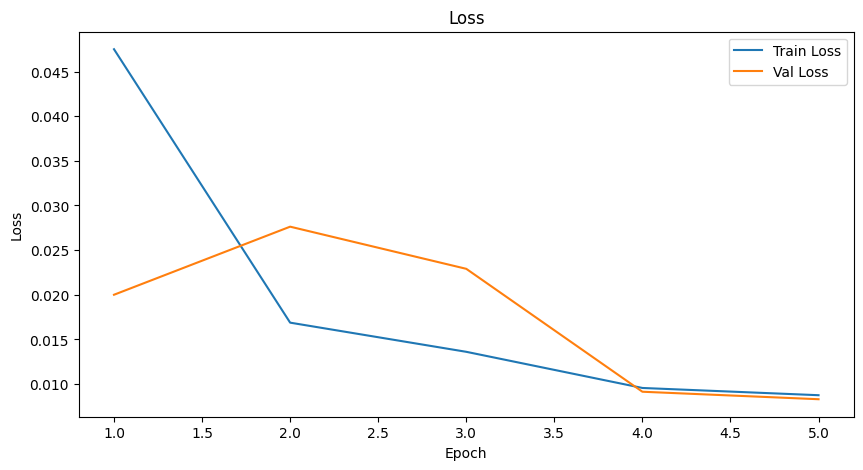

In [13]:
num_epochs = 5


train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)

## Визуализация

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
import torch

def apply_model_and_show(model, image_path, device, input_size=(512, 512), alpha=0.5):
    image = Image.open(image_path).convert('RGB')
    orig_size = image.size  

    processed_image = image.resize(input_size)
    image_tensor = TF.to_tensor(processed_image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        mask_pred_np = output.squeeze(0).squeeze(0).cpu().numpy()

    mask = (mask_pred_np > 0.5).astype(np.uint8)

    mask_img = Image.fromarray(mask * 255).resize(orig_size, resample=Image.NEAREST)
    mask_np = np.array(mask_img) / 255  

    image_np = np.array(image).astype(np.float32)

    color_mask = np.zeros_like(image_np)
    color_mask[..., 0] = 255  

    overlay_np = image_np * (1 - alpha * mask_np[..., None]) + color_mask * (alpha * mask_np[..., None])
    overlay_np = overlay_np.astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image)
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')

    axes[1].imshow(overlay_np)
    axes[1].set_title('Изображение с наложенной маской')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return fig


In [15]:
model = UNet()
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']


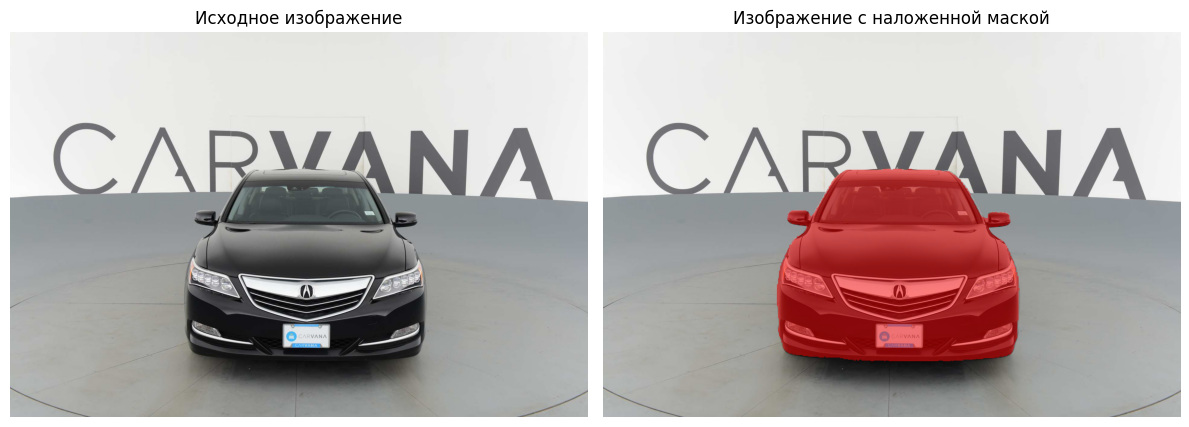

In [16]:

model.to(device) 

path_to_image = '/home/maksim/develops/python/MAKSIM/DL/4_Unet/dataset_2/images/00087a6bd4dc_01.jpg' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig = apply_model_and_show(model, path_to_image, device)

## 4. Оценка модели


В качестве метрики, оценивающей модель, воспользуемся [коэффициентом  Сёренсена](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%A1%D1%91%D1%80%D0%B5%D0%BD%D1%81%D0%B5%D0%BD%D0%B0), или Dice coefficient.   
Коэффициент Сёренсена можно использовать для сравнения попиксельного соответствия между прогнозируемой сегментацией и соответствующей ей истинной информацией.

In [17]:
import torch

def dice_coeff(pred, target, smooth=1e-6):
    """
    Вычисляет Dice коэффициент между предсказанием и целевой маской.
    """
    pred = pred.contiguous().view(pred.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    intersection = (pred * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (pred.sum(dim=1) + target.sum(dim=1) + smooth)
    return dice.mean().item()


def eval_model_with_dice(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            preds = (outputs > 0.5).float()
            dice_score = dice_coeff(preds, masks)
            epoch_dice += dice_score

    avg_loss = epoch_loss / len(data_loader)
    avg_dice = epoch_dice / len(data_loader)

    print(f"avg_dice {avg_dice:.4f} avg_loss {avg_loss:.4f}")

    return avg_loss, avg_dice


In [18]:
avg_loss, avg_dice = eval_model_with_dice(model, val_loader, criterion, device)

avg_dice 0.9927 avg_loss 0.6143


In [19]:
print("avg_dice", round(avg_dice, 4), "avg_loss", round(avg_loss, 4))


avg_dice 0.9927 avg_loss 0.6143


In [ ]:
len(val_loader)


128